In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.0.0+cu118


In [ ]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [ ]:
mnist_train = dset.MNIST(root = '../', train = True, transform = transforms.ToTensor(), target_transform = None, download = True) #mnist 학습 셋
mnist_test = dset.MNIST(root = '../', train = False, transform = transforms.ToTensor(), target_transform = None, download = True) # mnist 테스트 셋

100%|██████████| 9912422/9912422 [00:00<00:00, 93969575.95it/s]


Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 124882158.58it/s]


Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27219667.25it/s]


Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2054186.84it/s]


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



In [ ]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

# getitem써도 되고, 인덱싱 써도 되는데, 이번에는 getitem 써봄

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


In [ ]:
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, num_workers = 2, drop_last = True) #num_workers = 2(사용할 프로세스 개수.), drop_last(마지막 남는 데이터 처리)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers = 2, drop_last = True) #num_workers = 2(사용할 프로세스 개수.), drop_last(마지막 남는 데이터 처리)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5), #[1, 28, 28] -> [16, 24, 24](5x5 커널 지나서) , 필터개수1개(흑백) 에서 16개로 늘어나도록.
            nn.ReLU(), #
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5), # -> [32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # ->[32,10,10]
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5), # -> [64, 6, 6]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) #[64, 6, 6] -> [64, 3, 3]
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 3 * 3, 100), #[64*3*3. 100]
            nn.ReLU(),
            nn.Linear(100, 10) # -> [100,10]
        )

    def forward(self, x):
        out = self.layer(x) # [batch_size, 64, 3, 3]
        out = out.view(batch_size, -1)  # [batch_size, 64*3*3]

        out = self.fc_layer(out)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


model = CNN().to(device)

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [ ]:
## 학습.

loss_arr = []

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3828, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward0>)


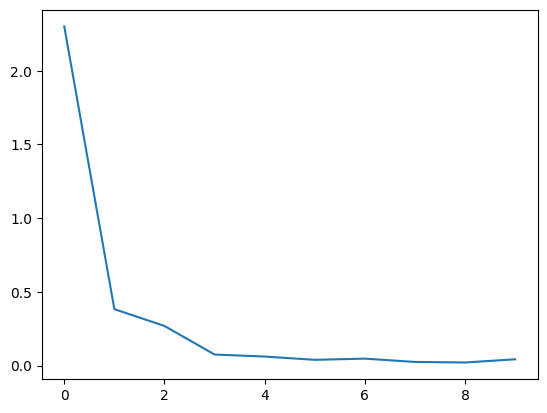

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
correct = 0
total = 0

# 인퍼런스 모드 위해 no_grad
with torch.no_grad():
    for image,label in test_loader:
        
        x = image.to(device)
        y_= label.to(device)
        output = model.forward(x)
        
        _,output_index = torch.max(output,1) # 최대값, 최대값 인덱스 뽑기.
        
        total += label.size(0)
        
        correct += (output_index == y_).sum().float() #아까 최대값 뽑아준거랑 라벨 일치하는거 correct에 하나씩 차곡차곡.
    
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.8581771850586%
